# Project: Evaluation of the Performance of Single Index Model (SIMs)
Now that we understand how to estimate single-index models, we will use them in upcoming lessons on portfolio allocation and decision-making. However, there are still unanswered questions about single-index models. For instance, do these models maintain the statistical properties of returns, also known as stylized facts? Additionally, can the predicted return for a specific stock using a single-index model be considered representative of the actual observed return for that stock? In other words, we need to test if single-index models are a reliable predictive tool.

### Learning objectives
In this project, we'll calculate the statistical properties of historical return data and compare them to properties calculated using single index models. First, we'll compute the excess returns for all tickers and filter out the excess return for `SPY.` Then, we'll calculate the excess return distributions of the single-index models and compare them with historical data.

* __Prerequisites__: we'll begin by loading the historical dataset. The data we'll explore is daily open-high-low-close values for firms in the [S&P500 index](https://en.wikipedia.org/wiki/S%26P_500) since `01-03-2018` until `10-31-2023`. We'll clean the data and compute the excess return for all tickers in the dataset, including `SPY` (our `market` portfolio).
* __Task 1__: Then, we'll compute the excess return distribution for all single index models in our collection and visualize the data's return distribution versus the single index model.
* __Task 2__: Finally, we'll develop tests to compute the similarity of the `data` versus `single-index` return distributions and compare some statistical properties.

## Setup
We set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our lab problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl");

## Prerequisites: Load and clean the historical dataset
We gathered a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2018` until `12-29-2023`, along with data for a few exchange-traded funds and volatility products during that time. We load the `orignal_dataset` by calling the `MyMarketDataSet()` function:

In [5]:
original_dataset = MyMarketDataSet() |> x-> x["dataset"];

### Clean the data
Not all of the tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquistion or de-listing events. Let's collect only those tickers with the maximum number of trading days.

* First, let's compute the number of records for a company that we know has a maximim value, e.g., `AAPL` and save that value in the `maximum_number_trading_days` variable:

In [7]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow;

Now, lets iterate through our data and collect only those tickers that have `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [9]:
dataset = Dict{String,DataFrame}();
for (ticker,data) ∈ original_dataset
    if (nrow(data) == maximum_number_trading_days)
        dataset[ticker] = data;
    end
end
dataset;

Let's get a list of firms that we have in cleaned up `dataset`, and save it in the `all_tickers` array

In [11]:
list_of_all_tickers = keys(dataset) |> collect |> sort;

### Compute the covariance, correlation, and expected return for all firms in the dataset
The expected growth $\mathbb{E}(r_{i})$ and covariance matrix $\Sigma$ will be used in our calculations, so we'll need to compute values for both of these quantities for the entire data set (all `N = 459` tickers), and then we'll filter out which tickers we are interested in. 
* First, we specify a value for the `risk_free_rate` variable, and the time step $\Delta{t}$

In [13]:
risk_free_rate = 0.0389; # hypothetical continuous compounded risk-free rate
Δt = (1/252); # units: year 1 x trading day

* Then we compute the expected (annualized) excess log growth rate by passing the `dataset` and the entire list of firms we have in the dataset (held in the $N\times{1}$ `all_array` array) to the [log_growth_matrix(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix). The result is stored in the `all_firms_return_matrix` variable, a $T-1\times{N}$ array of log return values. Each row of `all_firms_return_matrix` corresponds to a time value, while each column corresponds to a firm:

In [15]:
all_firms_excess_return_matrix = log_growth_matrix(dataset, list_of_all_tickers, Δt = Δt, 
    risk_free_rate = risk_free_rate);

* Next, we estimate the expected return for each firm from the `all_firms_return_matrix` using the `mean(...)` function, which is exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We set the $N\times{1}$ vector of expected values, i.e., $\mathbb{E}(r_{1}),\dotsc,\mathbb{E}(r_{N})$ to the array $\mu$:

In [17]:
μ = mean(all_firms_excess_return_matrix, dims=1) |> vec;

* Estimate the annualized `covariance_matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the `cov(...)` function, exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ covariance matrix in the $\Sigma$ variable:

In [19]:
Σ = cov(all_firms_excess_return_matrix) |> x-> x*(1/252) # annualized, historical volatility

460×460 Matrix{Float64}:
 0.0655367  0.0409146  0.0273076  …  0.0444449  0.0343089  0.0362875
 0.0409146  0.283809   0.0573645     0.069817   0.0986843  0.0383996
 0.0273076  0.0573645  0.12501       0.0392735  0.0510524  0.0292667
 0.0323065  0.0444841  0.0236737     0.045334   0.0268079  0.0336129
 0.0198861  0.0206277  0.0201981     0.0175898  0.0216887  0.0225977
 0.0317812  0.0228434  0.0180639  …  0.0300955  0.0202344  0.0301296
 0.0345523  0.0475915  0.0321036     0.0448403  0.0392157  0.0353211
 0.0387532  0.0358116  0.0245768     0.0519358  0.023438   0.0383791
 0.0383595  0.063833   0.0295398     0.055052   0.0425233  0.033446
 0.0209082  0.047045   0.0262508     0.0282589  0.0450202  0.0181709
 0.028523   0.0471555  0.0297807  …  0.0372987  0.0362684  0.030892
 0.0483308  0.0647852  0.0352406     0.0650439  0.041227   0.0429126
 0.0167745  0.0184331  0.0190468     0.0163051  0.0187535  0.0207827
 ⋮                                ⋱                        
 0.0225894  0.054666

* Estimate the annualized `correlation matrix` (assuming `252` trading days per year) from the `all_firms_return_matrix` using the [cor(...) function](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics.cor), exported by the [Statistics.jl package](https://docs.julialang.org/en/v1/stdlib/Statistics/). We store the $N\times{N}$ correlation matrix in the $ρ$ variable:

In [21]:
ρ = cor(all_firms_excess_return_matrix) # correlation matrix

460×460 Matrix{Float64}:
 1.0       0.300001  0.301695  0.479962  …  0.48165   0.333841  0.581071
 0.300001  1.0       0.304549  0.317579     0.36358   0.461435  0.29548
 0.301695  0.304549  1.0       0.254655     0.308162  0.359682  0.339325
 0.479962  0.317579  0.254655  1.0          0.47834   0.253979  0.52406
 0.304411  0.151737  0.223867  0.267654     0.191234  0.211721  0.363022
 0.5611    0.193803  0.230915  0.446208  …  0.37737   0.227813  0.55824
 0.557203  0.368804  0.374852  0.577663     0.51357   0.403288  0.597762
 0.497469  0.220908  0.22843   0.592591     0.473501  0.191866  0.517024
 0.534947  0.427773  0.298274  0.565422     0.545263  0.378167  0.489485
 0.352345  0.380973  0.320304  0.31355      0.338222  0.483813  0.321355
 0.486248  0.3863    0.367593  0.481361  …  0.451597  0.394284  0.55267
 0.547685  0.352786  0.289148  0.542806     0.523489  0.297925  0.510328
 0.312193  0.164855  0.256664  0.290533     0.215522  0.222574  0.405913
 ⋮                            

## Task 1: Compute the excess annual growth rate using single-index models

First, load the single index model file generated in this module's `worked example`. Save the collection of models in the `sim_model_dictionary::Dict{String, MySingleIndexModel}` dictionary.

In [24]:
sim_model_dictionary = load(joinpath(_PATH_TO_DATA,"SIMs-SP500-01-03-18-to-12-29-23.jld2")) |> x-> x["sim"] 

Dict{String, MySingleIndexModel} with 460 entries:
  "NI"   => MySingleIndexModel(-0.0671224, 0.652999, 0.0389, Normal{Float64}(μ=…
  "EMR"  => MySingleIndexModel(-0.0549877, 1.23526, 0.0389, Normal{Float64}(μ=-…
  "CTAS" => MySingleIndexModel(0.119417, 1.17936, 0.0389, Normal{Float64}(μ=-1.…
  "HSIC" => MySingleIndexModel(-0.0811194, 0.913675, 0.0389, Normal{Float64}(μ=…
  "KIM"  => MySingleIndexModel(-0.0818621, 1.28859, 0.0389, Normal{Float64}(μ=-…
  "PLD"  => MySingleIndexModel(0.0273092, 1.02836, 0.0389, Normal{Float64}(μ=1.…
  "IEX"  => MySingleIndexModel(-0.00940007, 0.963259, 0.0389, Normal{Float64}(μ…
  "BAC"  => MySingleIndexModel(-0.0922207, 1.32778, 0.0389, Normal{Float64}(μ=-…
  "CBOE" => MySingleIndexModel(-0.00982405, 0.588498, 0.0389, Normal{Float64}(μ…
  "EXR"  => MySingleIndexModel(0.0252878, 0.725388, 0.0389, Normal{Float64}(μ=0…
  "NCLH" => MySingleIndexModel(-0.336719, 2.32891, 0.0389, Normal{Float64}(μ=-2…
  "CVS"  => MySingleIndexModel(-0.0703279, 0.78292, 0.0389

Next, pull out the excess return of the `market portfolio` from the `all_firms_excess_return_matrix` computed in the prerequisites section. 
* To do this, look up the index for our market portfolio surrogate `SPY,` then get this column of data from the `all_firms_excess_return_matrix` using the [Julia findfirst(...) function](https://docs.julialang.org/en/v1/base/arrays/#Base.findfirst-Tuple{Function,%20Any}). Store the excess return data for `SPY` in the `Rₘ` variable.
* __Challenge__: Can you do this operation with a single line of code using the [Julia pipe operation](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping)

In [26]:
Rₘ = findfirst(x->x=="SPY", list_of_all_tickers) |> i -> all_firms_excess_return_matrix[:,i];

Given the market excess return `Rₘ` vector, compute the simulated return for all the tickers in the `list_of_all_tickers` using our [MySingleIndexModel instances](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MySingleIndexModel) for each trading period in the excess return `Rₘ` vector. Process each ticker in the `list_of_all_tickers` using a `for-loop`:
* First, look up the single model instance from the `sim_model_dictionary` and save this model instance in the `sim_model_ticker::MySingleIndexModel` variable.
* Next, compute the expected return using the single index model and the shortcut syntax `(model::MySingleIndexModel)(Rₘ::Array{Float64,1}, paths::Int64)::Array{Float64,2}.` This short-cut syntax takes a single index model instance, the market excess return `Rₘ` vector, and the number of sample paths we wish to compute and returns the sample array (trading periods on the rows, sample paths on the columns). We then compute the expected value of the simulated return from the sample matrix.
    * __Why do we compute samples and the expectation__? The single index model has an error term that captures the unmodeled residual between the simulated and observed return. Thus, we sample the error term and compute the expected value of the single index model return from the samples.
* Finally, we populate the `excess_return_sims::Array{Float64,2}` array with the simulated expected return for each trading period. The rows of the `excess_return_sims` hold the tickers, while the columns contain the expected excess return.

In [28]:
excess_return_sims = Array{Float64,2}(undef, length(sim_model_dictionary), length(Rₘ));
for i ∈ eachindex(list_of_all_tickers)

    sim_model_ticker = list_of_all_tickers[i] |> ticker -> sim_model_dictionary[ticker];
    R_ticker = sim_model_ticker(sort(Rₘ), 100) |> x-> mean(x, dims=2)

    for j ∈ eachindex(Rₘ)
       excess_return_sims[i,j] = R_ticker[j] 
    end
end
excess_return_sims;

## Task 2: Validation of the properties of the simulated distributions
Now that we have calculated the excess growth rate from the data, and using the single index model, we can compare the properties of the two growth rate distributions. In particular, we'll visualize the distributions first and then check for the absence of autocorrelation and the presence of short-term volatility clustering. Finally, we'll check whether the simulated and observed data are drawn from the same distribution.
* To start, select a ticker to analyze and store this value in the `ticker_to_analyze` variable:

In [30]:
ticker_to_analyze = "JNJ";

`Unhide` the code block below to see how we plotted the simulated and observed growth rate, i.e., scaled return for your `ticker_to_analyze` selection. We use the [density(...) function exported by the StatsPlots.jl package](https://docs.juliaplots.org/latest/api/#Plots.density-Tuple).
* __What do we expect__? We expect the return distribution for `ticker_to_analyze,` computed using the single index model, will only approximate the shape of the observed distribution. We expect this to be `true` because the single index model is a linear transformation of the market, i.e., the `SPY` distribution. Thus, as `ticker_to_analyze` becomes `close` in some sense to `SPY,` we'd expect the distributions to be similar, and if the `ticker_to_analyze = SPY,` the simulated and observed distributions should be identical. 

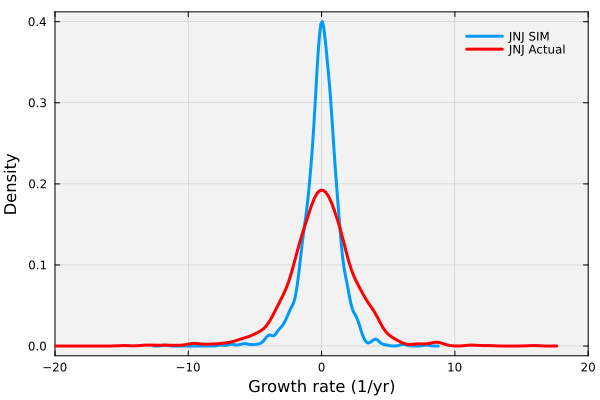

In [32]:
let
    index_to_visualize = findfirst(x->x==ticker_to_analyze, list_of_all_tickers)
    density(excess_return_sims[index_to_visualize,:], lw=3, 
        label="$(ticker_to_analyze) SIM", bg="gray95",
        background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    density!(all_firms_excess_return_matrix[:,index_to_visualize], 
        c=:red, xlims=(-20.0,20.0), label="$(ticker_to_analyze) Actual", 
            xlabel="Growth rate (1/yr)", ylabel="Density", lw=3)
end

In addition to the shape of the distribution, several other stylized facts, i.e., statistical properties of the return distribution, are interesting. We start by looking at the [autocorrelation of the return](https://www.investopedia.com/terms/a/autocorrelation.asp#:~:text=Autocorrelation%20can%20help%20determine%20if,next%20two%20days%2C%20as%20well.) and [volatility clustering](https://en.wikipedia.org/wiki/Volatility_clustering#:~:text=In%20finance%2C%20volatility%20clustering%20refers,be%20followed%20by%20small%20changes.%22). Then we'll look at the correlation between the simulated and observed returns series, and test whether the simulated and observed return distributions are drawn from the same distribution.

### Check: Autocorrelation of the simulated growth rate distribution
Autocorrelation is the correlation between a time series, e.g., a return time series, and a lagged version of the same series. Autocorrelation can be used to estimate the relationship between historical and future returns, i.e., is there a pattern in which past returns are predictive of future returns? We explore this question in the context of single index models by computing the autocorrelation of the simulated and observed return series. 
* First, for your choice of `ticker_to_analyze` select the column in the `all_firms_excess_return_matrix` that holds the observed excess return, and save this in the `Rᵢ` variable:

In [35]:
Rᵢ = all_firms_excess_return_matrix[:,findfirst(x-> x==ticker_to_analyze, list_of_all_tickers)];

Next, select the [MySingleIndexModel instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MySingleIndexModel) corresponding to your `ticker_to_analyze` from the `sim_model_dictionary,` and then compute the expected value for the simulated excess return using the short-cut syntax, assuming `1000` samples. Save the simulated expected excess return time series in the `R̄ᵢ::Vector{Float64}` variable:

In [37]:
sim_model_ticker = sim_model_dictionary[ticker_to_analyze];
R̄ᵢ = sim_model_ticker(Rₘ, 10000) |> x-> mean(x,dims=2) |> vec;

`Unhide` the code block below to see how we computed and visualized the autocorrelation of the simulated and return times series as a function of the number of lag periods.
* __What do we expect__? Given that the single index model is a linear transformation of the market, i.e., `SPY` return time series, we expect the autocorrelation of the single index model will decay to zero for `lag > 0.`
* __Why is this important__? As the autocorrelation $\rightarrow$ 0, the information about future return values as a function of past return values goes to zero. Thus, this suggests that past return information is not predictive of future return information.

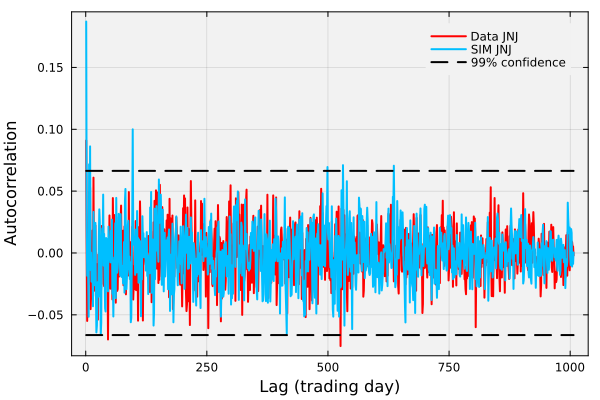

In [39]:
let
    number_of_steps = length(Rᵢ);
    number_of_lags = 1008; # approximately 1-trading year
 
    plot(autocor(Rᵢ, (1:(number_of_lags - 1) |> collect)), label="Data $(ticker_to_analyze)", lw=2, c=:red, 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent)
    plot!(autocor(R̄ᵢ, (1:(number_of_lags-1)) |> collect), label="SIM $(ticker_to_analyze)", lw=2, c=:deepskyblue1)
    LINE = (2.576/sqrt(number_of_steps))*ones(number_of_lags-1);
    plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (trading day)", fontsize=18)
    ylabel!("Autocorrelation", fontsize=18)
end

### Check: Volatility clustering of the simulated growth rate distribution
Large market swings, e.g., crashes or booms, tend to bunch up, followed by periods of relative calm. This isn't just chance; it follows from fear, optimism, news shocks, and investor behavior. When one big event occurs, it can send ripples that destabilize the market, making further volatility more likely.
* From [Mandelbrot (1963)](https://www.jstor.org/stable/2351623), "... large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes. ..."

Let's explore volatility clustering for the simulated and observed return series for your `ticker_to_analyze.` In this case, we will use the absolute value of the return as a measure of volatility clustering.

`Unhide` the code block below to see how we computed and visualized volatility clustering for the simulated and observed return time series for your `ticker_to_analyze.`
*  __What do we expect__? We expect the autocorrelation of the absolute value of the observed return time series for your `ticker_to_analyze` will have non-zero volatility clustering for some values of `lag,` but as `lag` becomes large, then we expect the volatility clustering to decay to zero.

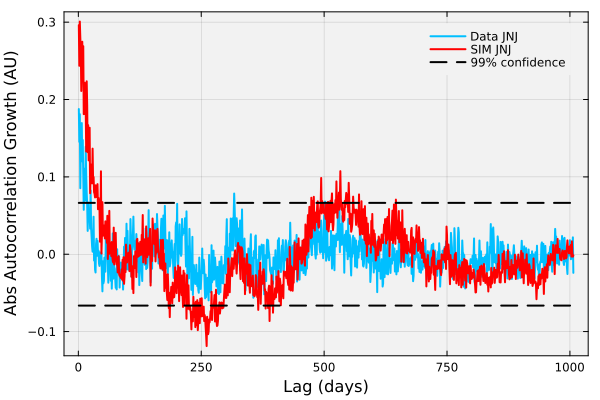

In [42]:
let
    number_of_steps = length(Rᵢ);
    number_of_lags = 1008; # approximately 4-trading year
    
    plot(autocor(abs.(Rᵢ), (1:(number_of_lags - 1) |> collect)),lw=2, label="Data $(ticker_to_analyze)", 
        bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent, c=:deepskyblue1)
    plot!(autocor(abs.(R̄ᵢ), (1:(number_of_lags - 1) |> collect)),lw=2, c=:red, label="SIM $(ticker_to_analyze)")
    LINE = (2.576/sqrt(number_of_steps))*ones(number_of_lags-1);
    plot!(LINE, label="99% confidence", lw=2, c=:black, ls=:dash)
    plot!(-LINE, label="", lw=2, c=:black, ls=:dash)
    xlabel!("Lag (days)",fontsize=18)
    ylabel!("Abs Autocorrelation Growth (AU)", fontsize=18)
end

### Check: What is the correlation between the simulated and observed growth rate distribution
Next, let's directly measure the relationship between the simulated and observed excess return distribution for your `ticker_to_analyze` by computing the [correlation between the time series](https://en.wikipedia.org/wiki/Correlation).
* Visualize the simulated excess growth rate versus the observed excess growth rate using the [scatter function exported by the Plots.jl package](https://github.com/JuliaPlots/Plots.jl). `Unhide` the code block below to see who we plot the simulated versus the observed growth rate for your `ticker_to_analyze.`
* __What do we expect__? If the simulated and observed excess growth rate distributions were identical, the values for the different trading periods should lie on the 45$^{\circ}$-line (`equality line`; red dashed line). The rotation of the data cloud around the origin indicates a discrepancy between the simulation and the observed growth rate data.

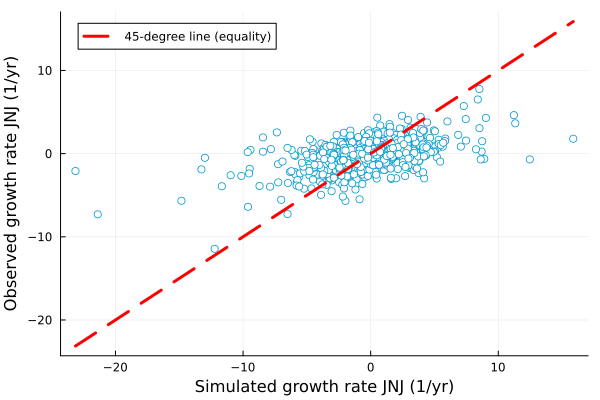

In [44]:
let
    # plot points -
    scatter(Rᵢ, R̄ᵢ, label="", msc=:deepskyblue3, c=:white);
    
    N = length(R̄ᵢ);
    xmin = minimum(Rᵢ);
    xmax = maximum(Rᵢ);
    ymin = minimum(R̄ᵢ);
    ymax = maximum(R̄ᵢ);
    X = range(xmin, stop=xmax, length=N) |> collect
    plot!(X,X, label="45-degree line (equality)", lw=3, ls=:dash, c=:red)
    xlabel!("Simulated growth rate $(ticker_to_analyze) (1/yr)", fontsize=18)
    ylabel!("Observed growth rate $(ticker_to_analyze) (1/yr)", fontsize=18)
end

While plotting the data visually represents the discrepancy of the simulated versus observed excess growth rate distribution, it is only a qualitative measure. We can compute the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) to quantify the relationship between the simulated and observed excess growth rate distributions.
* Use the [cor(...) function exported by the Statistics.jl package contained in Julia standard library](https://github.com/JuliaStats/Statistics.jl) to compute the correlation between the observed return `Rᵢ` and the expected simulated return `R̄ᵢ`.

In [46]:
println("The correlation between simulated and observed $(ticker_to_analyze) is: $(cor(Rᵢ, R̄ᵢ))")

The correlation between simulated and observed JNJ is: 0.500056714333059


### Check: Are the simulated and observed return distributions the same?
Finally, let's check if the observed and simulated growth rate distributions are drawn from the same underlying distribution using the [two-sample Kolmogorov-Smirnov test](https://juliastats.org/HypothesisTests.jl/stable/nonparametric/#HypothesisTests.ApproximateTwoSampleKSTest) exported by the [HypothesisTests.jl package](https://github.com/JuliaStats/HypothesisTests.jl). 
* The `H0:null hypothesis` is that the returns from the single index model and the data are drawn from the _same distribution_. The `H1:alternative` hypothesis is that they are drawn from _different distributions_. We `reject H0` if `pvalue`$\leq$`p_value_cutoff.`
* What do we expect? For any choice of `ticker_to_analyze` except `ticker_to_analyze = SPY,` we anticipate that the `H0:null hypothesis` will be rejected. This means the simulated and observed excess growth rates __are not drawn__ from the same distribution. The single index model is essentially a linear transformed market distribution, i.e., the `SPY` distribution. Therefore, it's unsurprising that `ticker_to_analyze` and `SPY` are not drawn from the same distribution, even in cases of high correlation.
* __Why is this important__? In later modules, we'll delve into the significance of single-index models. These models are crucial as they simulate the risk and return of tickers as a function of the market portfolio. Given that single index models generate a different distribution compared to the observed distribution, we can expect calculations using a single index to yield a different answer.  

In [48]:
KS_test_result_laplace = ApproximateTwoSampleKSTest(Rᵢ, R̄ᵢ)

Approximate two sample Kolmogorov-Smirnov test
----------------------------------------------
Population details:
    parameter of interest:   Supremum of CDF differences
    value under h_0:         0.0
    point estimate:          0.152621

Test summary:
    outcome with 95% confidence: reject h_0
    two-sided p-value:           <1e-14

Details:
    number of observations:   [1507,1507]
    KS-statistic:              4.189442286929621


## Disclaimer and Risks

__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team.

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.